### Set up imports

In [1]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from monai import transforms
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader
from monai.utils import first, set_determinism
from torch.cuda.amp import GradScaler, autocast
from torch.nn import L1Loss
from tqdm import tqdm

from generative.inferers import LatentDiffusionInferer
from generative.losses import PatchAdversarialLoss, PerceptualLoss
from generative.networks.nets import AutoencoderKL, DiffusionModelUNet, PatchDiscriminator
from generative.networks.schedulers import DDPMScheduler

print_config()

MONAI version: 1.3.0
Numpy version: 1.22.0
Pytorch version: 1.13.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: /<username>/miniconda3/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.3.0
Nibabel version: 5.2.1
scikit-image version: 0.21.0
scipy version: 1.10.1
Pillow version: 10.3.0
Tensorboard version: 2.7.0
gdown version: 4.7.3
TorchVision version: 0.14.1+cu117
tqdm version: 4.61.2
lmdb version: 1.4.1
psutil version: 5.9.8
pandas version: 2.0.3
einops version: 0.7.0
transformers version: 4.21.3
mlflow version: 2.11.3
pynrrd version: 1.0.0
clearml version: 1.15.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [2]:
# for reproducibility purposes set a seed
set_determinism(42)

### Setup a data directory and download dataset
Specify a MONAI_DATA_DIRECTORY variable, where the data will be downloaded. If not specified a temporary directory will be used.

In [3]:
os.environ["MONAI_DATA_DIRECTORY"] = "/root/GenerativeModels/data"
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/root/GenerativeModels/data


### Prepare data loader for the training set
Here we will download the Brats dataset using MONAI's `DecathlonDataset` class, and we prepare the data loader for the training set.

In [61]:
batch_size = 2
channel = 0  # 0 = Flair
assert channel in [0, 1, 2, 3], "Choose a valid channel"

train_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image","label"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.Lambdad(keys="image", func=lambda x: x[channel, :, :, :]),
        transforms.EnsureChannelFirstd(keys=["image","label"], channel_dim="no_channel"),
        transforms.EnsureTyped(keys=["image","label"]),
        transforms.Orientationd(keys=["image","label"], axcodes="RAS"),
        transforms.Spacingd(keys=["image","label"], pixdim=(2.4, 2.4, 2.2), mode=("bilinear")),
        transforms.CenterSpatialCropd(keys=["image","label"], roi_size=(96, 96, 64)),
        transforms.ScaleIntensityRangePercentilesd(keys="image", lower=0, upper=99.5, b_min=0, b_max=1),
    ]
)
train_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    section="training",  # validation
    cache_rate=1.0,  # you may need a few Gb of RAM... Set to 0 otherwise
    num_workers=8,
    download=True,  # Set download to True if the dataset hasnt been downloaded yet
    seed=0,
    transform=train_transforms,
)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=8, persistent_workers=True)
print(train_loader)
print(f'Image shape {train_ds[0]["image"].shape}')

2024-04-02 19:23:54,992 - INFO - Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
2024-04-02 19:23:54,993 - INFO - File exists: /root/GenerativeModels/data/Task01_BrainTumour.tar, skipped downloading.
2024-04-02 19:23:54,994 - INFO - Non-empty folder exists in /root/GenerativeModels/data/Task01_BrainTumour, skipped extracting.


Loading dataset: 100%|██████████| 388/388 [02:28<00:00,  2.61it/s]

Image shape torch.Size([1, 96, 96, 64])


torch.Size([1, 96, 96, 64])


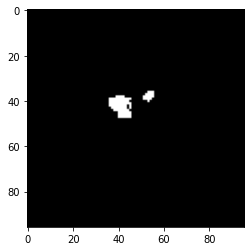

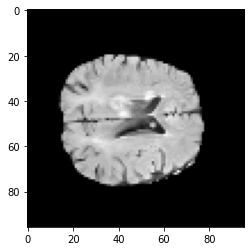

In [78]:
label_img = train_ds[1]["label"]
print(label_img.shape)
label_img[label_img!=0]=1

plt.imshow(label_img[0][:,:,35], cmap='gray')
plt.show()
plt.imshow(train_ds[1]["image"][0][:,:,35], cmap='gray')
plt.show()

Image shape torch.Size([1, 96, 96, 64])


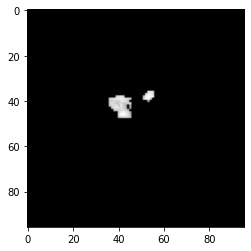

In [83]:
import os
import nibabel as nib
import numpy as np

# plt.imshow(train_ds[0]["image"][0][:,:,0], cmap='gray')
# plt.show()

for i, data in enumerate(train_ds):
    image, label = data["image"], data["label"]
    label[label!=0]=1
    for j in range(image.shape[0]):
       # Ensure data is in NumPy format for processing
        image_np = image[j].numpy() if hasattr(image[j], 'numpy') else image[j]
        label_np = label[0].numpy() if hasattr(label[0], 'numpy') else label[0]

        mask = label_np == 1
        selected_volumn=image_np * mask
        image_np = selected_volumn
        new_tensor = torch.from_numpy(image_np).to(dtype=image.dtype, device=image.device)
        #update train_ds
        train_ds[i]["image"][j] = new_tensor

print(f'Image shape {train_ds[0]["image"].shape}')
plt.imshow(train_ds[1]["image"][0][:,:,35], cmap='gray')
plt.show()

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=8, persistent_workers=True)

### Visualise examples from the training set

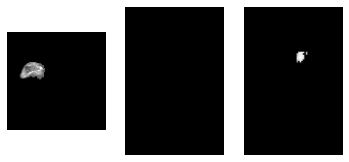

In [84]:
# Plot axial, coronal and sagittal slices of a training sample
check_data = first(train_loader)
idx = 0

img = check_data["image"][idx, 0]
fig, axs = plt.subplots(nrows=1, ncols=3)
for ax in axs:
    ax.axis("off")
ax = axs[0]
ax.imshow(img[..., img.shape[2] // 2], cmap="gray")
ax = axs[1]
ax.imshow(img[:, img.shape[1] // 2, ...], cmap="gray")
ax = axs[2]
ax.imshow(img[img.shape[0] // 2, ...], cmap="gray")
# plt.savefig("training_examples.png")

## Autoencoder KL

### Define Autoencoder KL network

In this section, we will define an autoencoder with KL-regularization for the LDM. The autoencoder's primary purpose is to transform input images into a latent representation that the diffusion model will subsequently learn. By doing so, we can decrease the computational resources required to train the diffusion component, making this approach suitable for learning high-resolution medical images.


In [85]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


In [86]:
autoencoder = AutoencoderKL(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    num_channels=(32, 64, 64),
    latent_channels=3,
    num_res_blocks=1,
    norm_num_groups=16,
    attention_levels=(False, False, True),
)
autoencoder.to(device)


discriminator = PatchDiscriminator(spatial_dims=3, num_layers_d=3, num_channels=32, in_channels=1, out_channels=1)
discriminator.to(device)

PatchDiscriminator(
  (initial_conv): Convolution(
    (conv): Conv3d(1, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    (adn): ADN(
      (D): Dropout(p=0.0, inplace=False)
      (A): LeakyReLU(negative_slope=0.2)
    )
  )
  (0): Convolution(
    (conv): Conv3d(32, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (adn): ADN(
      (N): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (D): Dropout(p=0.0, inplace=False)
      (A): LeakyReLU(negative_slope=0.2)
    )
  )
  (1): Convolution(
    (conv): Conv3d(64, 128, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (adn): ADN(
      (N): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (D): Dropout(p=0.0, inplace=False)
      (A): LeakyReLU(negative_slope=0.2)
    )
  )
  (2): Convolution(
    (conv): Conv3d(128, 256, kernel_size=(4, 4, 4), stride=(1, 1, 1), padding=(1, 1, 1), bias=Fal

### Defining Losses

We will also specify the perceptual and adversarial losses, including the involved networks, and the optimizers to use during the training process.

In [87]:
l1_loss = L1Loss()
adv_loss = PatchAdversarialLoss(criterion="least_squares")
loss_perceptual = PerceptualLoss(spatial_dims=3, network_type="squeeze", is_fake_3d=True, fake_3d_ratio=0.2)
loss_perceptual.to(device)


def KL_loss(z_mu, z_sigma):
    kl_loss = 0.5 * torch.sum(z_mu.pow(2) + z_sigma.pow(2) - torch.log(z_sigma.pow(2)) - 1, dim=[1, 2, 3, 4])
    return torch.sum(kl_loss) / kl_loss.shape[0]


adv_weight = 0.01
perceptual_weight = 0.001
kl_weight = 1e-6

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth


  0%|          | 0.00/4.73M [00:00<?, ?B/s]

In [88]:
optimizer_g = torch.optim.Adam(params=autoencoder.parameters(), lr=1e-4)
optimizer_d = torch.optim.Adam(params=discriminator.parameters(), lr=1e-4)

### Train model

In [89]:
n_epochs = 100
autoencoder_warm_up_n_epochs = 5
val_interval = 10
epoch_recon_loss_list = []
epoch_gen_loss_list = []
epoch_disc_loss_list = []
val_recon_epoch_loss_list = []
intermediary_images = []
n_example_images = 4

for epoch in range(n_epochs):
    autoencoder.train()
    discriminator.train()
    epoch_loss = 0
    gen_epoch_loss = 0
    disc_epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=110)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch["image"].to(device)  # choose only one of Brats channels

        # Generator part
        optimizer_g.zero_grad(set_to_none=True)
        reconstruction, z_mu, z_sigma = autoencoder(images)
        kl_loss = KL_loss(z_mu, z_sigma)

        recons_loss = l1_loss(reconstruction.float(), images.float())
        p_loss = loss_perceptual(reconstruction.float(), images.float())
        loss_g = recons_loss + kl_weight * kl_loss + perceptual_weight * p_loss

        if epoch > autoencoder_warm_up_n_epochs:
            logits_fake = discriminator(reconstruction.contiguous().float())[-1]
            generator_loss = adv_loss(logits_fake, target_is_real=True, for_discriminator=False)
            loss_g += adv_weight * generator_loss

        loss_g.backward()
        optimizer_g.step()

        if epoch > autoencoder_warm_up_n_epochs:
            # Discriminator part
            optimizer_d.zero_grad(set_to_none=True)
            logits_fake = discriminator(reconstruction.contiguous().detach())[-1]
            loss_d_fake = adv_loss(logits_fake, target_is_real=False, for_discriminator=True)
            logits_real = discriminator(images.contiguous().detach())[-1]
            loss_d_real = adv_loss(logits_real, target_is_real=True, for_discriminator=True)
            discriminator_loss = (loss_d_fake + loss_d_real) * 0.5

            loss_d = adv_weight * discriminator_loss

            loss_d.backward()
            optimizer_d.step()

        epoch_loss += recons_loss.item()
        if epoch > autoencoder_warm_up_n_epochs:
            gen_epoch_loss += generator_loss.item()
            disc_epoch_loss += discriminator_loss.item()

        progress_bar.set_postfix(
            {
                "recons_loss": epoch_loss / (step + 1),
                "gen_loss": gen_epoch_loss / (step + 1),
                "disc_loss": disc_epoch_loss / (step + 1),
            }
        )
    epoch_recon_loss_list.append(epoch_loss / (step + 1))
    epoch_gen_loss_list.append(gen_epoch_loss / (step + 1))
    epoch_disc_loss_list.append(disc_epoch_loss / (step + 1))

del discriminator
del loss_perceptual
torch.cuda.empty_cache()

Epoch 99: 100%|███████| 194/194 [01:52<00:00,  1.72it/s, recons_loss=0.00702, gen_loss=0.902, disc_loss=0.048]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


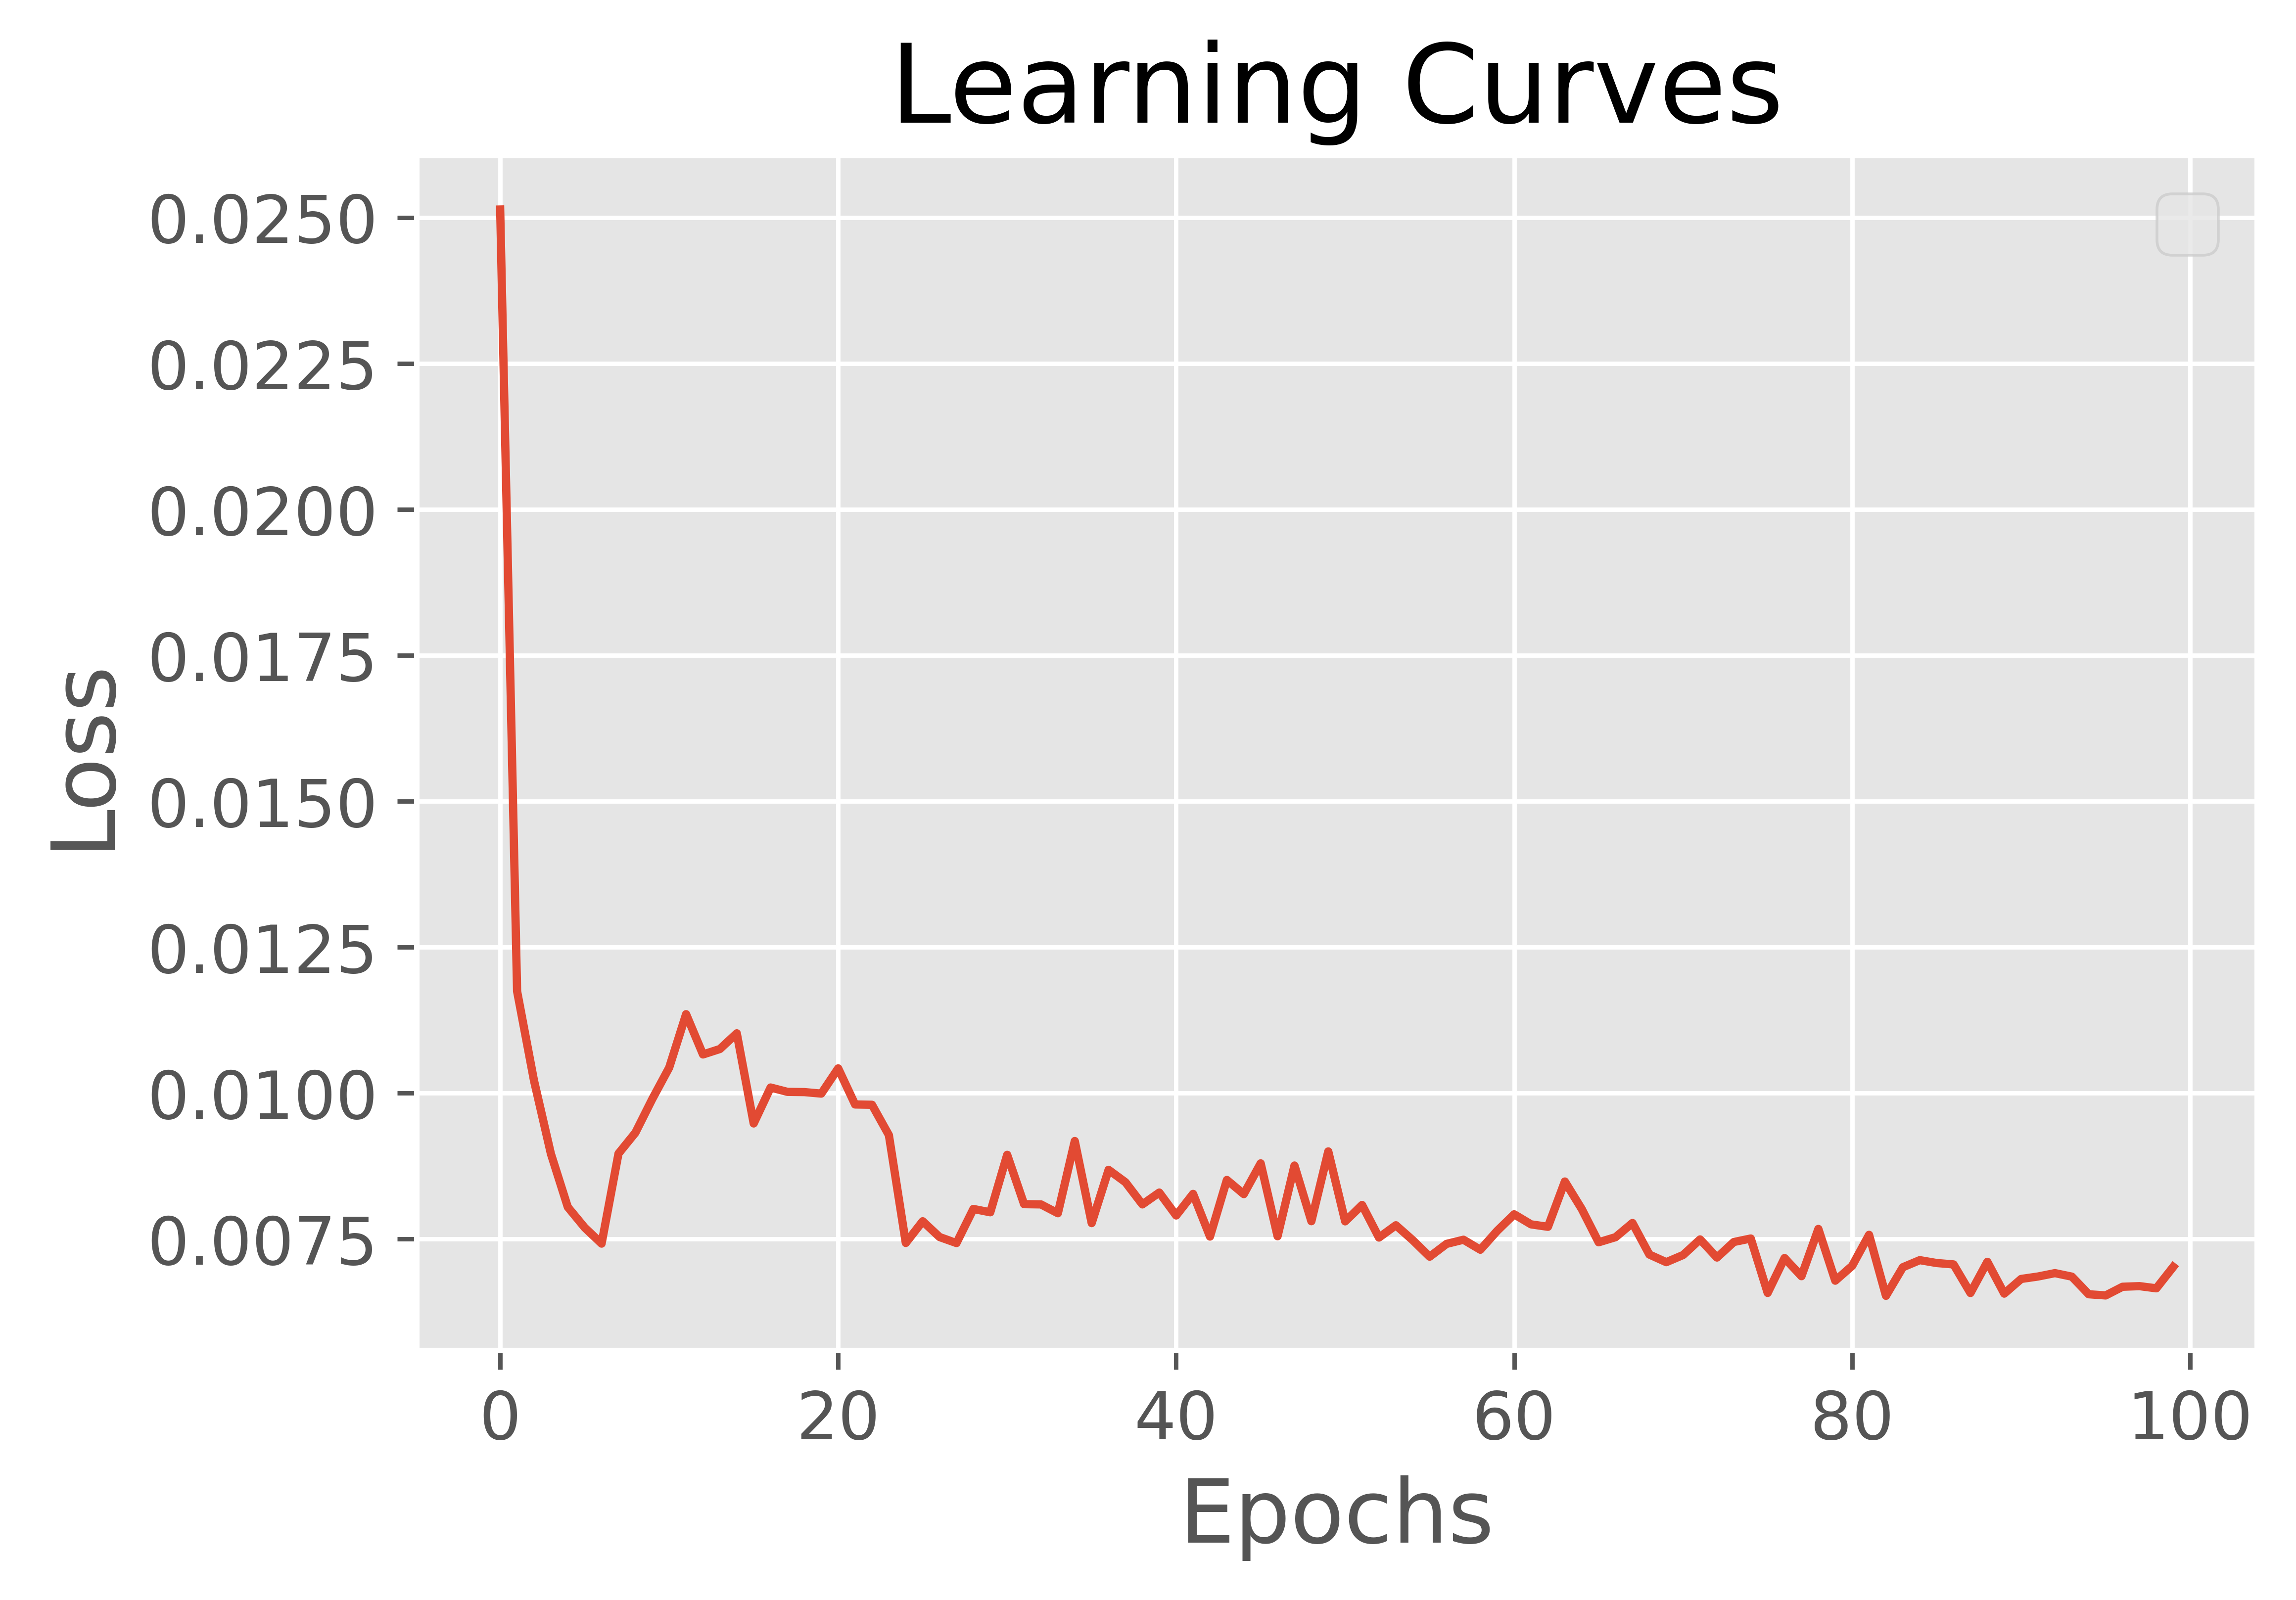

In [91]:
plt.figure(dpi=800)
plt.style.use("ggplot")
plt.title("Learning Curves", fontsize=20)
plt.plot(epoch_recon_loss_list)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.legend(prop={"size": 14})
plt.show()

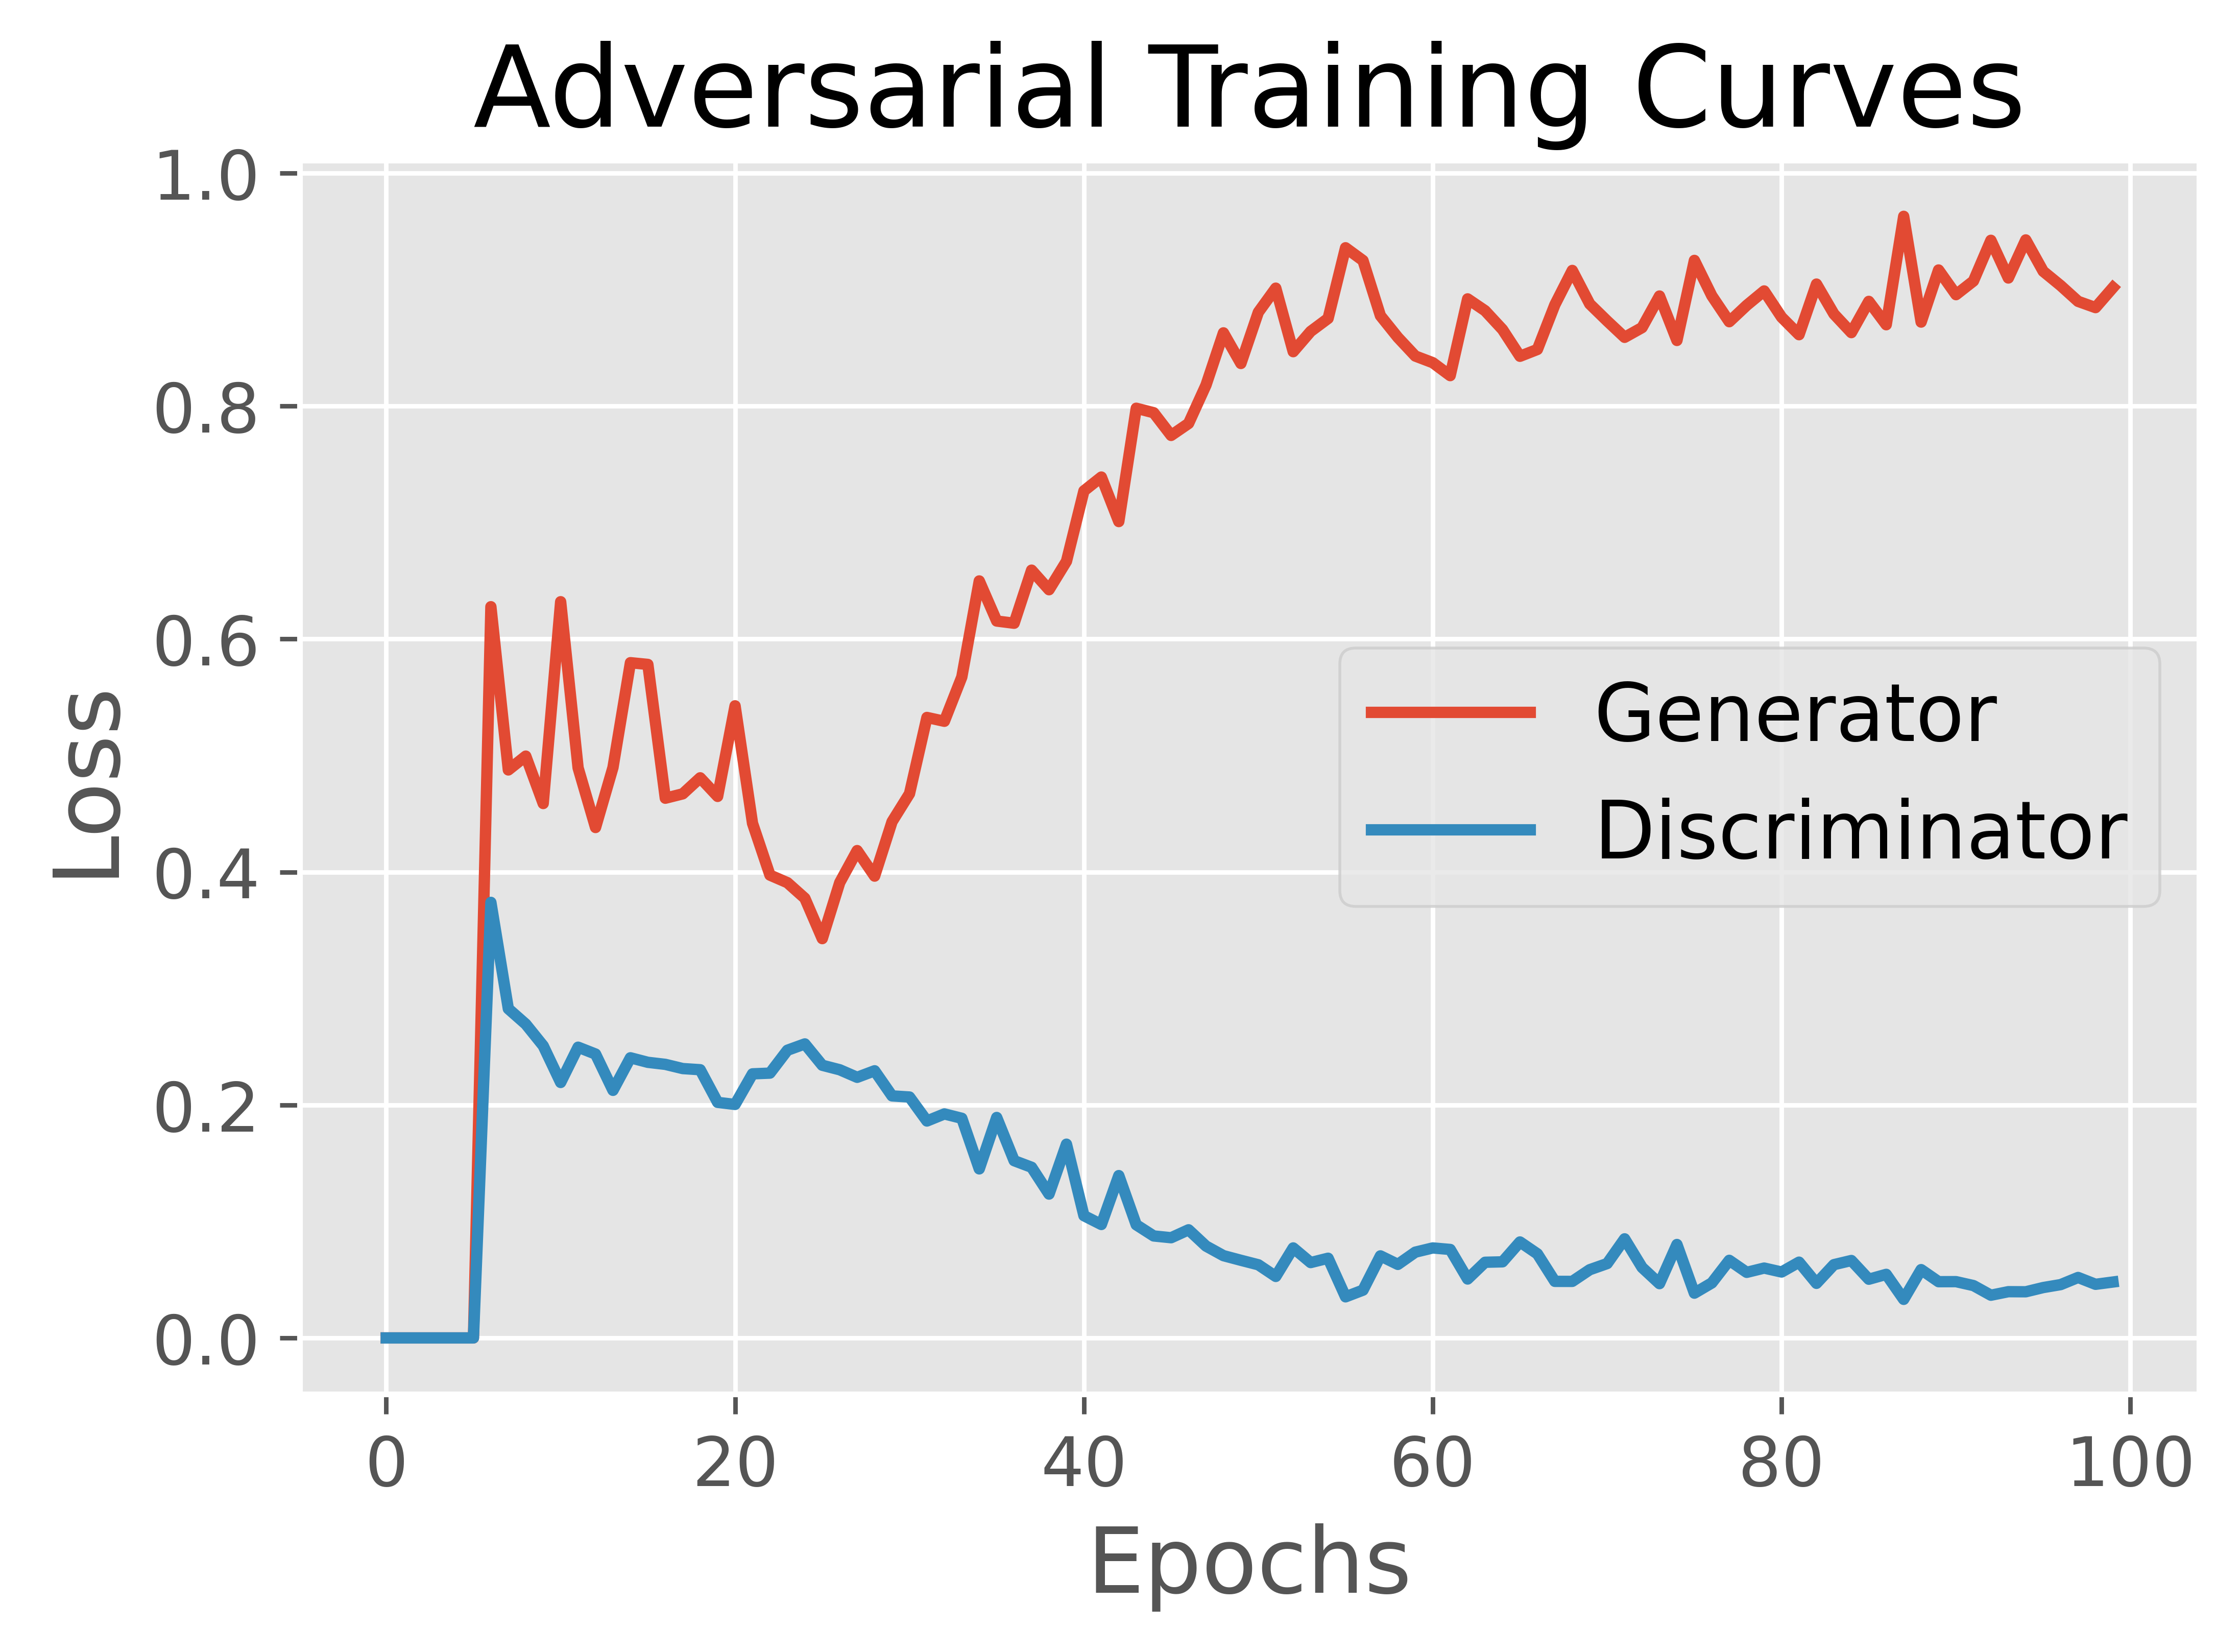

In [92]:
plt.figure(dpi=800)
plt.title("Adversarial Training Curves", fontsize=20)
plt.plot(epoch_gen_loss_list, color="C0", linewidth=2.0, label="Generator")
plt.plot(epoch_disc_loss_list, color="C1", linewidth=2.0, label="Discriminator")
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.legend(prop={"size": 14})
plt.show()

### Visualise reconstructions

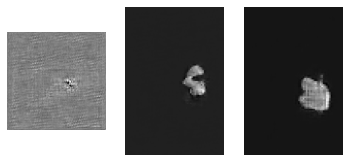

In [93]:
# Plot axial, coronal and sagittal slices of a training sample
idx = 0
img = reconstruction[idx, channel].detach().cpu().numpy()
fig, axs = plt.subplots(nrows=1, ncols=3)
for ax in axs:
    ax.axis("off")
ax = axs[0]
ax.imshow(img[..., img.shape[2] // 2], cmap="gray")
ax = axs[1]
ax.imshow(img[:, img.shape[1] // 2, ...], cmap="gray")
ax = axs[2]
ax.imshow(img[img.shape[0] // 2, ...], cmap="gray")

## Diffusion Model

### Define diffusion model and scheduler

In this section, we will define the diffusion model that will learn data distribution of the latent representation of the autoencoder. Together with the diffusion model, we define a beta scheduler responsible for defining the amount of noise tahat is added across the diffusion's model Markov chain.

In [94]:
unet = DiffusionModelUNet(
    spatial_dims=3,
    in_channels=3,
    out_channels=3,
    num_res_blocks=1,
    num_channels=(32, 64, 64),
    attention_levels=(False, True, True),
    num_head_channels=(0, 64, 64),
)
unet.to(device)


scheduler = DDPMScheduler(num_train_timesteps=1000, schedule="scaled_linear_beta", beta_start=0.0015, beta_end=0.0195)

### Scaling factor

As mentioned in Rombach et al. [1] Section 4.3.2 and D.1, the signal-to-noise ratio (induced by the scale of the latent space) can affect the results obtained with the LDM, if the standard deviation of the latent space distribution drifts too much from that of a Gaussian. For this reason, it is best practice to use a scaling factor to adapt this standard deviation.

_Note: In case where the latent space is close to a Gaussian distribution, the scaling factor will be close to one, and the results will not differ from those obtained when it is not used._


In [95]:
with torch.no_grad():
    with autocast(enabled=True):
        z = autoencoder.encode_stage_2_inputs(check_data["image"].to(device))

print(f"Scaling factor set to {1/torch.std(z)}")
scale_factor = 1 / torch.std(z)

Scaling factor set to 1.0044231414794922


We define the inferer using the scale factor:

In [96]:
inferer = LatentDiffusionInferer(scheduler, scale_factor=scale_factor)

In [97]:
optimizer_diff = torch.optim.Adam(params=unet.parameters(), lr=1e-4)

### Train diffusion model

In [98]:
n_epochs = 150
epoch_loss_list = []
autoencoder.eval()
scaler = GradScaler()

first_batch = first(train_loader)
z = autoencoder.encode_stage_2_inputs(first_batch["image"].to(device))

for epoch in range(n_epochs):
    unet.train()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=70)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch["image"].to(device)
        optimizer_diff.zero_grad(set_to_none=True)

        with autocast(enabled=True):
            # Generate random noise
            noise = torch.randn_like(z).to(device)

            # Create timesteps
            timesteps = torch.randint(
                0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
            ).long()

            # Get model prediction
            noise_pred = inferer(
                inputs=images, autoencoder_model=autoencoder, diffusion_model=unet, noise=noise, timesteps=timesteps
            )

            loss = F.mse_loss(noise_pred.float(), noise.float())

        scaler.scale(loss).backward()
        scaler.step(optimizer_diff)
        scaler.update()

        epoch_loss += loss.item()

        progress_bar.set_postfix({"loss": epoch_loss / (step + 1)})
    epoch_loss_list.append(epoch_loss / (step + 1))

Epoch 149: 100%|████████| 194/194 [00:22<00:00,  8.55it/s, loss=0.236]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


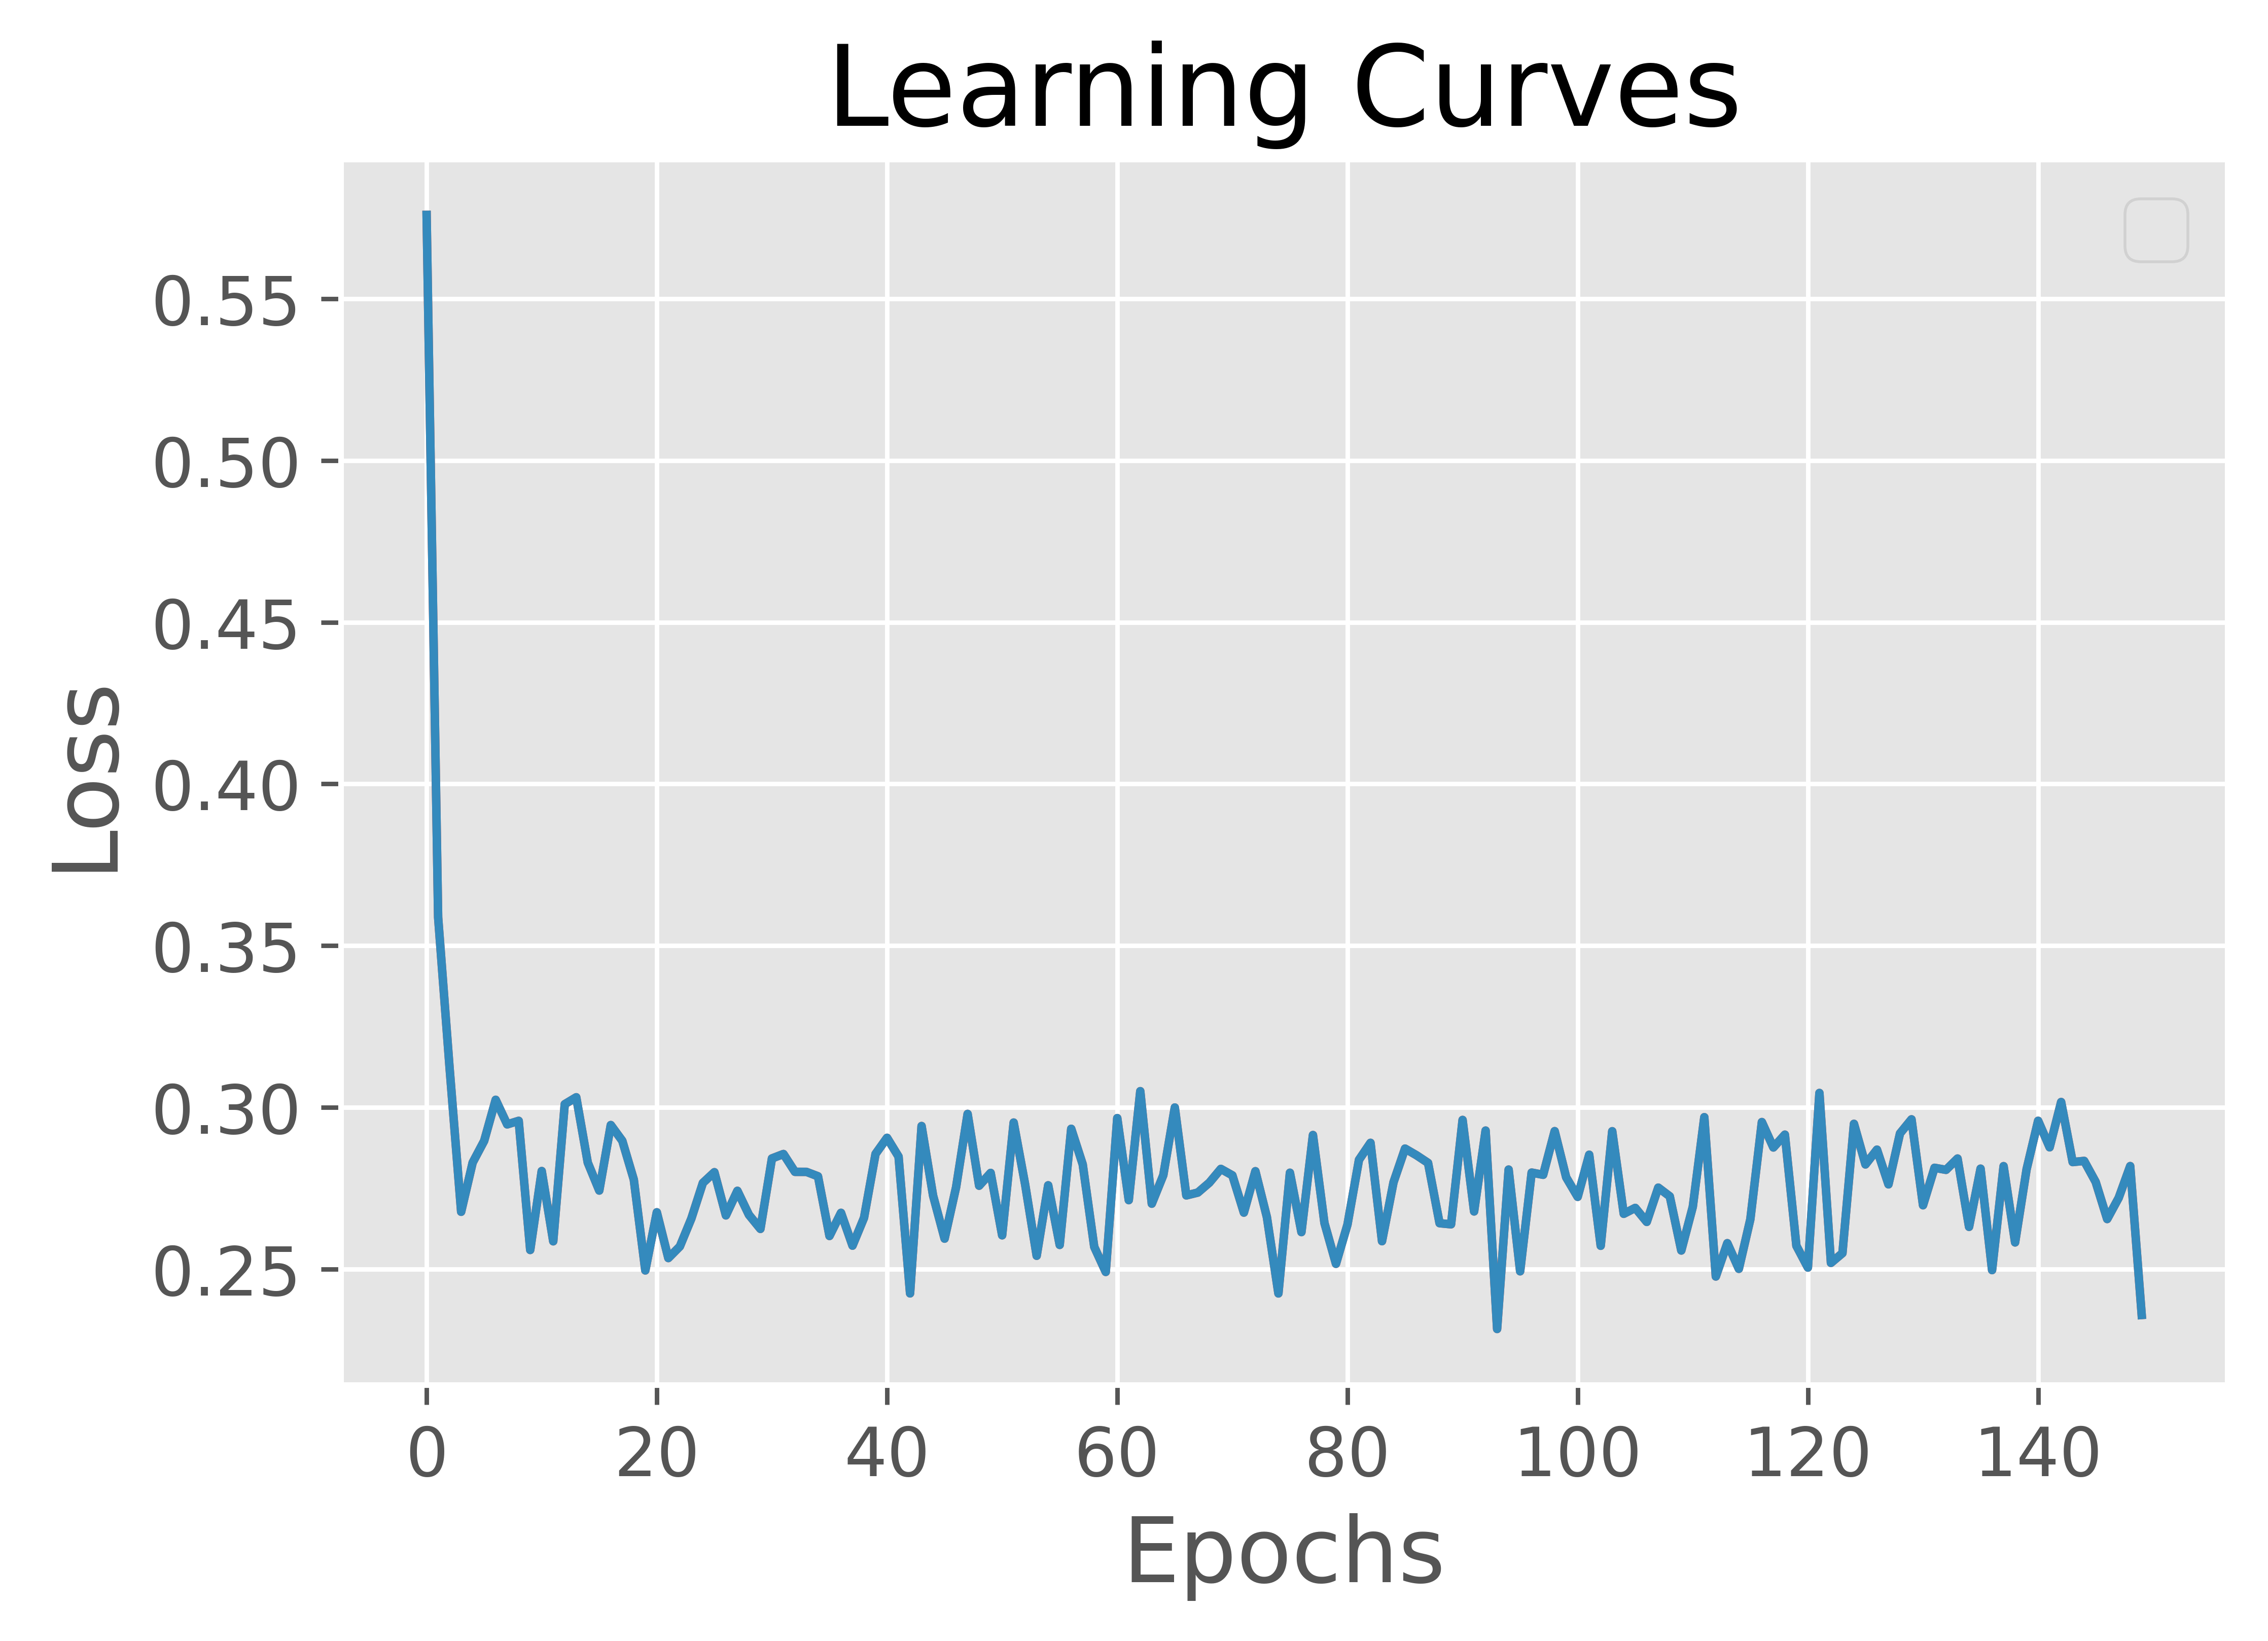

In [99]:
plt.figure(dpi=800)
plt.plot(epoch_loss_list)
plt.title("Learning Curves", fontsize=20)
plt.plot(epoch_loss_list)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.legend(prop={"size": 14})
plt.show()

### Plotting sampling example

Finally, we generate an image with our LDM. For that, we will initialize a latent representation with just noise. Then, we will use the `unet` to perform 1000 denoising steps. In the last step, we decode the latent representation and plot the sampled image.

In [100]:
autoencoder.eval()
unet.eval()

#save model
torch.save(autoencoder.state_dict(), 'autoencoder.pth')
torch.save(unet.state_dict(), 'unet.pth')

noise = torch.randn((1, 3, 24, 24, 16))
noise = noise.to(device)
scheduler.set_timesteps(num_inference_steps=1000)
synthetic_images = inferer.sample(
    input_noise=noise, autoencoder_model=autoencoder, diffusion_model=unet, scheduler=scheduler
)
#save synthetic images nii.gz
flag=0
images_path = 'synthetic_images'
if not os.path.exists(images_path):
    os.makedirs(images_path)
for images in synthetic_images:
    flag+=1
    images = images.squeeze()
    synthetic_images_np = images.cpu().detach().numpy()
    nifti_img = nib.Nifti1Image(synthetic_images_np, affine=np.eye(4))
    nib.save(nifti_img, os.path.join(images_path, f"synthetic_image_{flag}.nii.gz"))
    print(f"Image {flag} saved")

100%|██████████| 1000/1000 [00:11<00:00, 85.96it/s]


Image 1 saved


### Visualise synthetic data

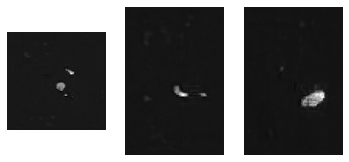

In [101]:
idx = 0
img = synthetic_images[idx, channel].detach().cpu().numpy()  # images
fig, axs = plt.subplots(nrows=1, ncols=3)
for ax in axs:
    ax.axis("off")
ax = axs[0]
ax.imshow(img[..., img.shape[2] // 2], cmap="gray")
ax = axs[1]
ax.imshow(img[:, img.shape[1] // 2, ...], cmap="gray")
ax = axs[2]
ax.imshow(img[img.shape[0] // 2, ...], cmap="gray")

2024-04-03 04:28:54,592 - INFO - Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
2024-04-03 04:28:54,593 - INFO - File exists: /root/GenerativeModels/data/Task01_BrainTumour.tar, skipped downloading.
2024-04-03 04:28:54,593 - INFO - Non-empty folder exists in /root/GenerativeModels/data/Task01_BrainTumour, skipped extracting.


100%|██████████| 1000/1000 [00:11<00:00, 86.33it/s]


Label data shape: torch.Size([96, 96, 64])
Label data shape: (96, 96, 64)
Target shape: (21, 11, 15)
Found 5 features.
Number of slices: 5


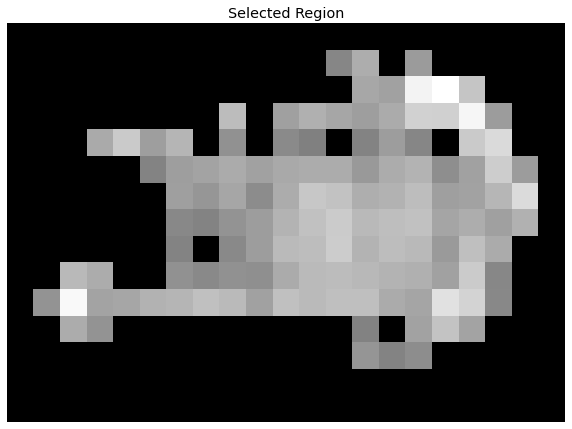

(21, 11, 15)
找到有效起始点：(49, 48, 29)


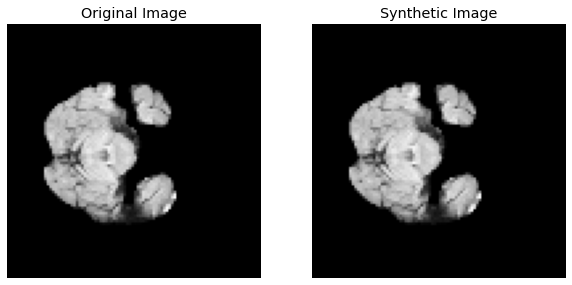

In [159]:

# 加载原始图像
original_img_data = train_ds[1]["image"][0]

# 确保图像数据是numpy数组
original_img_data = np.array(original_img_data)


noise = torch.randn((1, 3, 24, 24, 16))
noise = noise.to(device)
scheduler.set_timesteps(num_inference_steps=1000)
synthetic_images = inferer.sample(
    input_noise=noise, autoencoder_model=autoencoder, diffusion_model=unet, scheduler=scheduler
)

synthetic_images_np = synthetic_images.cpu().detach().numpy().squeeze()
mask=synthetic_images_np>0.5
synthetic_images_np=mask.astype(int)*synthetic_images_np

label_data = train_ds[1]["label"][0]
print(f"Label data shape: {label_data.shape}")
mask_data = np.where(label_data > 0, 1, 0)
print(f"Label data shape: {mask_data.shape}")

#random coeff [0,1]
coeff1 = 1-np.random.uniform(0.5,0.9)
coeff2 = 1-np.random.uniform(0.5,0.9)
coeff3 = 1-np.random.uniform(0.5,0.9)
#size=coeff*label_data.shape
target_shape = (int(coeff1*mask_data.shape[0]), int(coeff2*mask_data.shape[1]), int(coeff3*mask_data.shape[2]))
print(f"Target shape: {target_shape}")
# 找到所有独立的块
labeled_array, num_features = label(mask)
slices = find_objects(labeled_array)
print(f"Found {num_features} features.")
print(f"Number of slices: {len(slices)}")
for slice in slices:
    #如果slice的面积大小小于target_shape 1/3，则跳过
    area1 = np.prod([s.stop - s.start for s in slice])
    area2 = np.prod(target_shape)
    if area1 > area2 / 3:
        selected_slice = slice
        break

selected_region = synthetic_images_np[selected_slice]
new_img = nib.Nifti1Image(selected_region, affine=np.eye(4))

plt.figure(figsize=(10, 10))
plt.imshow(selected_region[:, :, 5], cmap='gray')
plt.title('Selected Region')
plt.axis('off')
plt.show()

# 保存为 .nii.gz 文件
nib.save(new_img, 'selected_region.nii.gz')

# target_shape = (24, 24, 16)
scale_factors = (
    target_shape[0] / selected_region.shape[0],
    target_shape[1] / selected_region.shape[1],
    target_shape[2] / selected_region.shape[2],
)
resized_region = resize(
    selected_region, 
    output_shape=target_shape, 
    order=1,  # order=1 表示双线性插值，对于大多数图像数据来说是合适的
    mode='reflect', 
    cval=0, 
    clip=True, 
    preserve_range=True, 
    anti_aliasing=True
).astype(selected_region.dtype)



#保存合成图像
synthetic_image = nib.Nifti1Image(resized_region, affine=np.eye(4))
nib.save(synthetic_image, 'synthetic_image.nii.gz')

print(resized_region.shape)

# 替换指定区域
valid_region = (label_data == 0) & (original_img_data > 0)
max_x, max_y, max_z = original_img_data.shape[0] - target_shape[0], original_img_data.shape[1] - target_shape[1], original_img_data.shape[2] - target_shape[2]
def is_valid_start(start_x, start_y, start_z, target_shape, valid_region):
    """检查从给定起点开始的区域是否完全有效"""
    end_x, end_y, end_z = start_x + target_shape[0], start_y + target_shape[1], start_z + target_shape[2]
    return np.all(valid_region[start_x:end_x, start_y:end_y, start_z:end_z])

# 尝试找到一个有效的起始点
for attempt in range(1000):  # 尝试次数上限
    start_x = np.random.randint(0, max_x + 1)
    start_y = np.random.randint(0, max_y + 1)
    start_z = np.random.randint(0, max_z + 1)
    
    if is_valid_start(start_x, start_y, start_z, target_shape, valid_region):
        print(f"找到有效起始点：({start_x}, {start_y}, {start_z})")
        break
else:
    print("未能找到有效的起始点。")

end_x, end_y, end_z = start_x + target_shape[0], start_y + target_shape[1], start_z + target_shape[2]

# synthetic_image_np
threshold = 0.5  # 定义阈值，可以根据需要调整
mask = resized_region >= threshold
temp_array = original_img_data[start_x:end_x, start_y:end_y, start_z:end_z].copy()
temp_array[mask] = resized_region[mask]
original_img_data[start_x:end_x, start_y:end_y, start_z:end_z] = temp_array

# original_img_data[start_x:end_x, start_y:end_y, start_z:end_z] = synthetic_images_np

# 创建一个新的 NIfTI 图像
modified_img_nii = nib.Nifti1Image(original_img_data, affine=original_img_nii.affine)

#展示与原图不同的部分
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(train_ds[1]["image"][0][:, :, 10], cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(original_img_data[:, :, 10], cmap='gray')
plt.title('Synthetic Image')
plt.axis('off')
plt.show()

# 保存修改后的图像
nib.save(modified_img_nii, 'modified_test.nii.gz')

## Clean-up data

In [21]:
if directory is None:
    shutil.rmtree(root_dir)